reference: 

[Multivariate Time Series Forecasting with LSTMs in Keras](https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/)



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import datetime
import os

In [2]:
cwd = os.getcwd()
f_S1 = '/data/DATA_CME_S1_22012021.csv'
f_SAC = '/data/DATA_NOAA_SAC_2020-01-01_2020-12-31.csv'

# data

In [20]:
d_s1 = pd.read_csv(cwd+f_S1)
d_sac = pd.read_csv(cwd+f_SAC)

In [21]:
d_s1.head()

,Date,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
0,2021-01-21,1369.00,1387.00,1365.50,1367.50,0.75,1370.25,108662.0,358270.0
1,2021-01-20,1384.50,1384.50,1352.00,1368.75,-16.25,1369.50,171018.0,366235.0
2,2021-01-19,1419.00,1421.25,1383.25,1385.00,-31.00,1385.75,121099.0,374876.0
3,2021-01-15,1432.25,1434.50,1413.50,1424.75,-13.75,1416.75,95665.0,378606.0
4,2021-01-14,1413.00,1413.00,1413.00,1411.75,25.50,1436.50,12.0,52.0


In [22]:
d_sac.head()

,DATE,PRCP_IL,SNOW_IL,SNWD_IL,PRCP_SD,SNOW_SD,SNWD_SD,TMAX_SD,TMIN_SD,PRCP_MI,...,SNOW_OH,SNWD_OH,TMAX_OH,TMIN_OH,PRCP_TN,SNOW_TN,SNWD_TN,TMAX_TN,TMIN_TN,TOBS_TN
0,2020-01-01,0.0,0,0,0,0.0,380.0,28,-105,18.0,...,0.0,30.0,33,-27,0,0,0,111,-17,-17
1,2020-01-02,0.0,0,0,10,0.0,330.0,17,-16,0.0,...,0.0,0.0,83,6,64,0,0,133,-17,72
2,2020-01-03,0.0,0,0,20,43.0,300.0,17,-149,0.0,...,0.0,0.0,100,72,399,0,0,139,72,133
3,2020-01-04,56.0,53,51,0,0.0,360.0,-21,-193,0.0,...,10.0,0.0,72,-5,51,0,0,156,22,33
4,2020-01-05,0.0,0,25,0,0.0,360.0,56,-71,NaN,...,0.0,0.0,44,-10,0,0,0,67,-22,39


## subset the data since 2010-01-01

In [24]:
df_s1 = d_s1[['Date', 'Settle']]
df_s1.loc[:,'Date'] = pd.to_datetime(df_s1.loc[:,'Date'])
df_s1 = df_s1[df_s1.loc[:,'Date'] >= '2010-01-01']

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [7]:
df_s1.head()

,Date,Settle
0,2021-01-21,1370.25
1,2021-01-20,1369.50
2,2021-01-19,1385.75
3,2021-01-15,1416.75
4,2021-01-14,1436.50


In [8]:
df_s1.tail()

,Date,Settle
2781,2010-01-08,1013.00
2782,2010-01-07,1017.75
2783,2010-01-06,1050.50
2784,2010-01-05,1052.25
2785,2010-01-04,1049.50


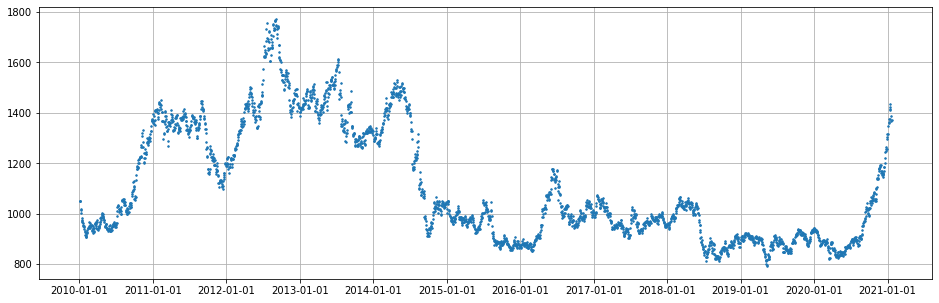

In [11]:
import matplotlib.dates as mdates

fig, ax = plt.subplots(figsize=(16, 5))
plt.plot_date(x=df_s1.Date, y=df_s1.Settle, ms=1.5)
ax.xaxis.set_major_locator(mdates.YearLocator())
plt.grid()

In [26]:
d_sac['DATE'] = pd.to_datetime(d_sac['DATE'])

In [33]:
df = pd.merge(df_s1, d_sac, how='inner', left_on='Date', right_on='DATE')
df.index = df['Date']
df = df.drop(['Date', 'DATE'], axis=1)

In [34]:
df.tail()

,Settle,PRCP_IL,SNOW_IL,SNWD_IL,PRCP_SD,SNOW_SD,SNWD_SD,TMAX_SD,TMIN_SD,PRCP_MI,...,SNOW_OH,SNWD_OH,TMAX_OH,TMIN_OH,PRCP_TN,SNOW_TN,SNWD_TN,TMAX_TN,TMIN_TN,TOBS_TN
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-08,938.25,0.0,0,0,0,0.0,300.0,-77,-210,0.0,...,18.0,0.0,22,-82,0,0,0,128,0,0
2020-01-07,935.00,0.0,0,0,0,0.0,300.0,-43,-216,0.0,...,0.0,0.0,67,-27,0,0,0,156,11,17
2020-01-06,932.75,0.0,0,0,0,0.0,300.0,0,-138,48.0,...,0.0,0.0,56,-10,0,0,0,167,22,44
2020-01-03,930.50,0.0,0,0,20,43.0,300.0,17,-149,0.0,...,0.0,0.0,100,72,399,0,0,139,72,133
2020-01-02,944.25,0.0,0,0,10,0.0,330.0,17,-16,0.0,...,0.0,0.0,83,6,64,0,0,133,-17,72


## convert the TS to supervised ML dataset

reference: 

[How to Convert a Time Series to a Supervised Learning Problem in Python](https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/)

In [79]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations (oldest first) as a list or NumPy array;
              NOTE: the order of the list is .
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    agg = agg.iloc[N_IN:,:]
    if dropnan:
        agg.dropna(inplace=True, axis=1)
    return agg

In [80]:
df.sort_index(ascending=True).tail()

,Settle,PRCP_IL,SNOW_IL,SNWD_IL,PRCP_SD,SNOW_SD,SNWD_SD,TMAX_SD,TMIN_SD,PRCP_MI,...,SNOW_OH,SNWD_OH,TMAX_OH,TMIN_OH,PRCP_TN,SNOW_TN,SNWD_TN,TMAX_TN,TMIN_TN,TOBS_TN
Date,,,,,,,,,,,,,,,,,,,,,
2020-12-24,1263.50,20.0,0,0,0,0.0,30.0,-105,-216,15.0,...,112.0,0.0,117,-66,279,0,0,167,-17,-11
2020-12-28,1255.25,0.0,0,0,0,0.0,0.0,-21,-155,64.0,...,0.0,50.0,83,-10,0,0,0,183,94,100
2020-12-29,1295.50,0.0,0,0,76,94.0,0.0,-32,-110,0.0,...,0.0,30.0,11,-60,0,0,0,128,-6,-6
2020-12-30,1303.75,NaN,76,76,0,NaN,NaN,-32,-138,58.0,...,NaN,NaN,89,-10,0,0,0,133,-11,128
2020-12-31,1315.25,0.0,0,51,0,0.0,100.0,-60,-149,41.0,...,18.0,30.0,6,-10,597,0,0,206,28,28


In [81]:
values = df.sort_index(ascending=True).values

In [82]:
N_IN = 7
N_OUT = 1

In [83]:
reshaped = series_to_supervised(values, n_in=N_IN, n_out=N_OUT, dropnan=True)
reshaped.index = df.sort_index(ascending=True).index[N_IN:]

In [84]:
reshaped.dropna(inplace=True, axis=1)

In [85]:
reshaped.head()

,var1(t-7),var2(t-7),var3(t-7),var4(t-7),var5(t-7),var6(t-7),var7(t-7),var8(t-7),var9(t-7),var11(t-7),...,var35(t),var44(t),var47(t),var48(t),var49(t),var50(t),var51(t),var52(t),var53(t),var54(t)
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-13,944.25,0.0,0.0,0.0,10.0,0.0,330.0,17.0,-16.0,0.0,...,0.0,0.0,78.0,11.0,0.0,0.0,0.0,117.0,6.0,106.0
2020-01-14,930.50,0.0,0.0,0.0,20.0,43.0,300.0,17.0,-149.0,0.0,...,0.0,0.0,128.0,6.0,104.0,0.0,0.0,144.0,6.0,111.0
2020-01-15,932.75,0.0,0.0,0.0,0.0,0.0,300.0,0.0,-138.0,36.0,...,58.0,10.0,117.0,17.0,18.0,0.0,0.0,194.0,106.0,167.0
2020-01-16,935.00,0.0,0.0,0.0,0.0,0.0,300.0,-43.0,-216.0,0.0,...,0.0,5.0,67.0,-32.0,437.0,0.0,0.0,200.0,56.0,89.0
2020-01-17,938.25,0.0,0.0,0.0,0.0,0.0,300.0,-77.0,-210.0,0.0,...,0.0,3.0,-27.0,-49.0,0.0,0.0,0.0,100.0,17.0,22.0


In [98]:
dropColumns = [x for x in reshaped.columns if ('(t)' in x) and (x not in ['var1(t)'])] 

In [100]:
reshaped = reshaped.drop(dropColumns, axis=1)

## training/test data split

In [102]:
reshaped.loc[reshaped.index >= '2020-12-01'].shape[0]

22

In [103]:
# split into train and test sets
train = reshaped.loc[reshaped.index < '2020-12-01']
test = reshaped.loc[reshaped.index >= '2020-12-01']

In [104]:
# split into input and outputs
train_X, train_y = train.iloc[:, :-1], train.iloc[:, -1]
test_X, test_y = test.iloc[:, :-1], test.iloc[:, -1]

> Finally, the inputs (X) are reshaped into the 3D format expected by LSTMs, namely [samples, timesteps, features]

In [105]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.values.reshape((train_X.shape[0], N_OUT, train_X.shape[1]))
test_X = test_X.values.reshape((test_X.shape[0], N_OUT, test_X.shape[1]))

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(224, 1, 219) (224,) (22, 1, 219) (22,)


# model

## design network

In [106]:
import tensorflow as tf

In [107]:
# design network

EPOCHS = 500
BATCH_SIZE = 77
TRAIN_SPLIT = 0.87
LOSS_FUNCTION = 'mse' # 'mse': Mean Square Error, 'mae': Mean Absolute Error, 'binary_crossentropy'
LEARNING_RATE = 0.001 #0.001
NEURONS = 128

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.LSTM(NEURONS, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True, name='lstm1'))
model.add(tf.keras.layers.LSTM(NEURONS, name='lstm2'))
model.add(tf.keras.layers.Dense(1, activation='relu', name='output'))
optimizer = tf.keras.optimizers.Adam(lr=LEARNING_RATE)
model.compile(loss=LOSS_FUNCTION, optimizer=optimizer)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm1 (LSTM)                 (None, 1, 128)            178176    
_________________________________________________________________
lstm2 (LSTM)                 (None, 128)               131584    
_________________________________________________________________
output (Dense)               (None, 1)                 129       
Total params: 309,889
Trainable params: 309,889
Non-trainable params: 0
_________________________________________________________________


In [108]:
tf.keras.utils.plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


## train the model

In [109]:
# fit network
history = model.fit(
    train_X, 
    train_y, 
    epochs=EPOCHS, 
    batch_size=BATCH_SIZE, 
    validation_split=0.1, 
    verbose=1, 
    shuffle=False)

Epoch 1/500
3/3 [==============================] - 4s 462ms/step - loss: 793387.7812 - val_loss: 1279577.7500
Epoch 2/500
3/3 [==============================] - 0s 19ms/step - loss: 792657.2969 - val_loss: 1278655.2500
Epoch 3/500
3/3 [==============================] - 0s 21ms/step - loss: 791856.9844 - val_loss: 1277475.2500
Epoch 4/500
3/3 [==============================] - 0s 20ms/step - loss: 790893.0938 - val_loss: 1276057.7500
Epoch 5/500
3/3 [==============================] - 0s 23ms/step - loss: 789679.7031 - val_loss: 1274285.3750
Epoch 6/500
3/3 [==============================] - 0s 21ms/step - loss: 788282.1094 - val_loss: 1272373.2500
Epoch 7/500
3/3 [==============================] - 0s 20ms/step - loss: 786756.8281 - val_loss: 1270211.6250
Epoch 8/500
3/3 [==============================] - 0s 20ms/step - loss: 785105.9844 - val_loss: 1268058.3750
Epoch 9/500
3/3 [==============================] - 0s 22ms/step - loss: 783392.2969 - val_loss: 1265808.3750
Epoch 10/500
3/3 [

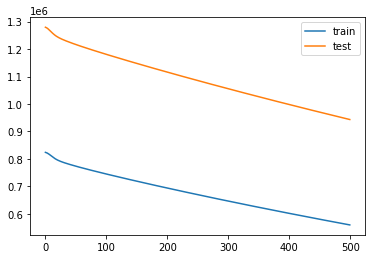

In [110]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [111]:
train_yhat = model.predict(train_X)
train_pred_y = pd.Series(train_yhat.reshape(len(train_yhat)), index=train_y.index)

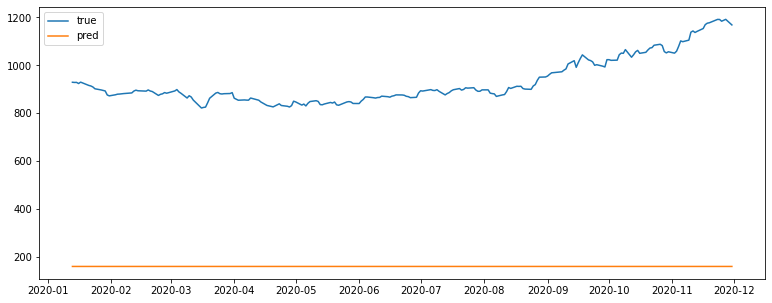

In [112]:
# Make the plotting-canvas bigger.
plt.figure(figsize=(13,5))

# Plot and compare the two signals.
plt.plot(train_y, label='true')
plt.plot(train_pred_y, label='pred')

# Plot labels etc.
plt.legend()
plt.show()

In [113]:
# prediction
yhat = model.predict(test_X)
pred_y = pd.Series(yhat.reshape(len(yhat)), index=test_y.index)

In [114]:
from sklearn.metrics import mean_squared_error

rmse = np.sqrt(mean_squared_error(test_y, pred_y))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 1048.192


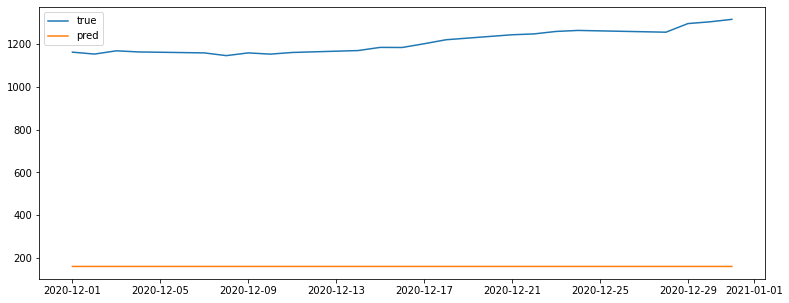

In [115]:
plt.figure(figsize=(13,5))

plt.plot(test_y, label='true')
plt.plot(pred_y, label='pred')

# Plot labels etc.
plt.legend()
plt.show()